# Run Study - #423

## Introduction

* Display waveforms for events of this run.
* Look for highest and second-to-highest pulses in the waveform.
* Find TOF from average of TOF1 and TOF0 counters.
* Look for charge distribution of Pb-glass calorimeter.
* Apply cuts and look at 1D TOF distribution.

## Building a display for TOF counters

In [51]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [3]:
def load_waveform(event_number, root_file_path):
    
    branches = ["midas_data_D300", "midas_data_D301", "midas_data_D302"]
    channels = [f"Channel{i}" for i in range(0,8)]
    waveforms = np.ndarray(shape=(24), dtype="object")
    ch_counter = 0
    
    with uproot.open(root_file_path) as root_file:
        for br in branches:
            for ch in channels:
                waveform_ch = root_file[br].arrays([ch, "eventNumber"], library="np")
                
                if ch == "Channel0":
                    waveform_index = np.where(waveform_ch["eventNumber"]==event_number)
                    entry = waveform_index[0][0]
                
                waveforms[ch_counter] = waveform_ch[ch][entry]
                ch_counter += 1
    
    return waveforms

In [4]:
def load_information(event_number, npz_file_path):
    data = np.load(npz_file_path, allow_pickle=True)
    print("Looking for pulse information...")
    entry = np.where(data["event_number"]==event_number)[0][0]
    return data["count"][entry], data["baseline"][entry], data["CFD_timing"][entry], data["amplitude"][entry]

Loading the waveform and information. 
"%%timeit" measured 8.73 s $\pm$ 39.7 ms for this operation.

In [14]:
def plot_waveforms(event_number, run_number, waveforms, pulses=np.array([]), fmt='ro', title=''):
    
    # 14-bit @ 500 MS/s
    h_factor = 1./500.e6*1.e9
    titles = ["ACT0-R", "ACT0-L", "ACT1-R", "ACT1-L", "ACT3-R", "ACT3-L", 
              "Trigger Sci.", "Pb-Glass", "TOF0", "TOF0", "TOF0", "TOF0", "TOF1", "TOF1", "TOF1", "TOF1"]
    
    fig, ((ax0, ax1, ax2, ax3), (ax4, ax5, ax6, ax7), (ax8, ax9, ax10, ax11), (ax12, ax13, ax14, ax15)) = plt.subplots(nrows=4, ncols=4, sharey=True, sharex=True, figsize=(16,12))
    axes_act = [ax0, ax1, ax2,   ax3,  ax4,  ax5,  ax6,  ax7]
    axes_tof = [ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]
    
    axes = axes_act+axes_tof
    for i in range(0, len(axes)):

        sample = h_factor*np.arange(0, len(waveforms[i]))
        
        axes[i].set_xlim([sample[0],sample[-1]])
        axes[i].set_title(f"{titles[i]} (Ch. {i})")

        # Plot ACT, Pb-Glass and TOF
        waveform = waveforms[i]
        
        if i == 7: 
            waveform = waveforms[15] 
            sample = h_factor*np.arange(0, len(waveforms[15]))
            axes[i].set_title(f"{titles[i]} (Ch. {16})")
        axes[i].plot(sample, waveform, "black")
        
        
        
        # Plot CFD timing
        if len(pulses) > 0:
            to_plot = pulses[i]
            if i == 7: to_plot = pulses[15]
            zeros = np.zeros(len(to_plot))
            for j in range(0, len(to_plot)):
                axes[i].plot(to_plot[j]*h_factor, zeros[j], fmt)

        # Axis labels
        if i%4 == 0:
            axes[i].set_ylabel("Amplitude (mV)")

    for ax in axes[12:]: ax.set_xlabel("Time (ns)")
    title = f"Run {run_number} - Event {event_number} - Ch0-16"
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.savefig(f"./plots/{title}.png", dpi=300)

## Running the Display

In [17]:
# Scale factors
h_factor = 1./500.e6*1.e9
v_factor = 1./16384.*2.*1.e3
event_number = 10
run_number = 432
npz_file_path  = "../data/pulse_information-000432.npz"
count, baseline, timing_in, amplitude_in  = load_information(event_number, npz_file_path)
root_file_path = "../data/root_run_000432.root"
waveforms_in = load_waveform(event_number, root_file_path)

Looking for pulse information...


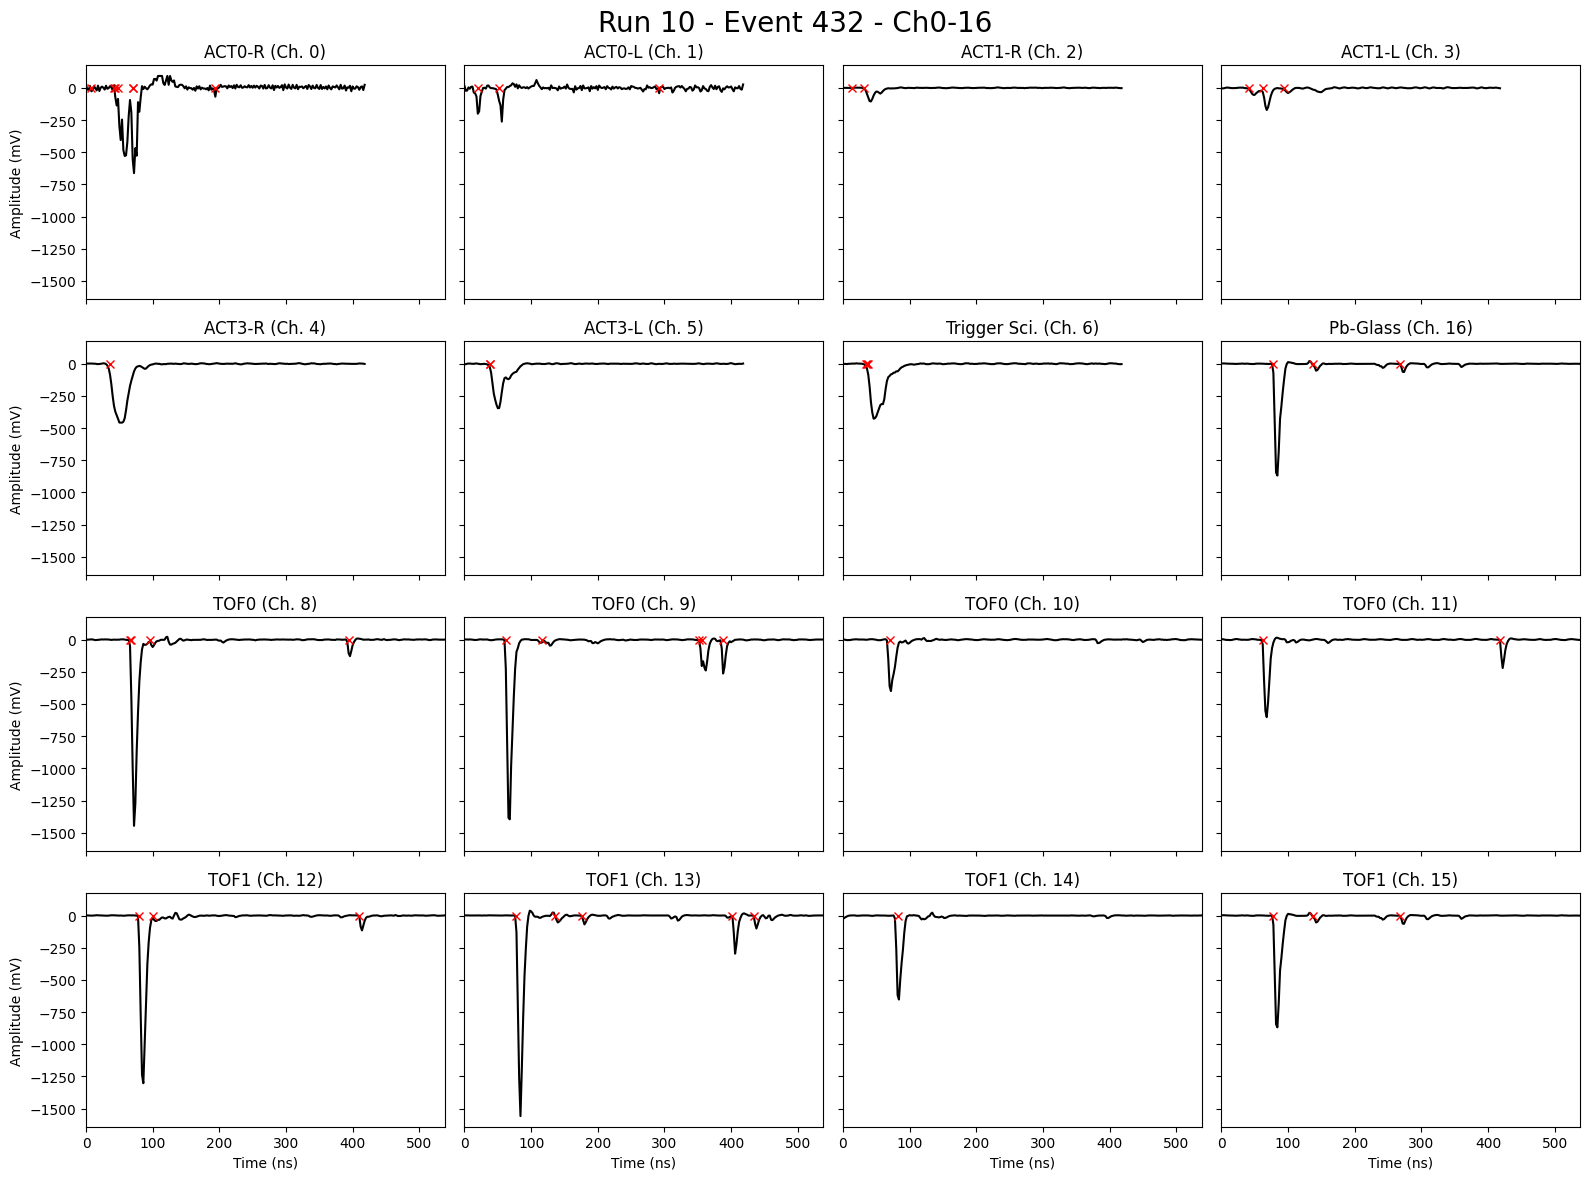

In [18]:
# Plot waveform
amplitude = amplitude_in*v_factor
timing = timing_in*h_factor
timing = [timing_in[i][abs(amplitude[i]) > 40] for i in range(0,16)]
waveforms = np.add(v_factor*waveforms_in, -v_factor*baseline)
plot_waveforms(432, event_number, waveforms, timing, fmt='rx')

## TOF Measurements

### Objective

* Sort pulses in waveform by height.
* Find pulse timing average for each pulse order.
* Subtract average of TOF1 from TOF0.


In [19]:
def generate_TOF_array(timing, amplitude, N):
    
    sorted_timing = np.ndarray(shape=(8), dtype="object")
    TOF_j = np.array([], dtype="float")
    for i in range(8,16):
        sorted_j      = np.argsort(amplitude[i])
        sorted_timing[i-8] = timing[i][sorted_j]

    for j in range(0, N):
        TOF0_j = np.average([sorted_timing[i][j] for i in range(0,4) if len(timing[i]) > j ])
        TOF1_j = np.average([sorted_timing[i][j] for i in range(4,8) if len(timing[i]) > j ])
        TOF_j  = np.append(TOF_j, [TOF1_j - TOF0_j], axis = None)
        
    return TOF_j

In [20]:
timing = timing_in*h_factor
amplitude = amplitude*v_factor

TOF = generate_TOF_array(timing, amplitude, 2)
print(TOF[0], TOF[1])

14.0 -25.0


### Running TOF calculation for several events

In [24]:
def load_all_information(npz_file_path):
    data = np.load(npz_file_path, allow_pickle=True)
    return data["count"], data["baseline"], data["CFD_timing"], data["amplitude"], data["event_number"]

In [25]:
count, baseline, timing, amplitude, event_number = load_all_information(npz_file_path)
number_of_events = int(1.*len(count))
print("Loading file... Done.")

Loading file... Done.


In [18]:
TOF.shape

(2,)

In [19]:
amplitude[:,0].shape

(112264,)

In [26]:
def generate_TOF_array2(timing, amplitude, N):
    
    sorted_timing = np.ndarray(shape=(8), dtype="object")
    TOF_j = np.array([], dtype="object")
    for i in range(8,16):
        sorted_j           = np.argsort(amplitude[i])
        sorted_timing[i-8] = timing[i][sorted_j]

    # print(sorted_timing)

    for j in range(0, N):
        
        time_value0 = 0.
        time_counter0 = 0
        for i in range(0, 4):
            
            if len(sorted_timing[i]) > j:
                # print("sorted: ", i,j, sorted_timing[i][j])
                time_counter0 += 1
                time_value0   += sorted_timing[i][j]
        if time_counter0 == 0:
            time_value0 = None
        else:
            time_value0 = time_value0/time_counter0
        # print("time0", time_value0)

        time_value1 = 0.
        time_counter1 = 0
        for i in range(4, 8):
            if len(sorted_timing[i]) > j:
                time_counter1 += 1
                time_value1   += sorted_timing[i][j]
        if time_counter1 == 0:
            time_value1 = None
        else:
            time_value1 = time_value1/time_counter1
        # print("time1", time_value1)
        
        if (time_value1 == None or time_value0 == None):
            TOF_j = np.append(TOF_j, [None], axis=None)
        else:
            TOF_j = np.append(TOF_j, [time_value1 - time_value0], axis=None)

    return TOF_j
    

In [27]:
N = 2
TOF = np.ndarray(shape=(len(amplitude)), dtype="object")
TOF0 = []
TOF1 = []
for i in range(0, int(1.*len(amplitude))):
    TOF =  generate_TOF_array2(timing[i], amplitude[i], N)
    TOF0.append(TOF[0])
    TOF1.append(TOF[1])
# print(TOF[0].shape)

## Plotting Amplitude by TOF to Find Slices

* Load all amplitude information
* Load all TOF
* Plot 2D scatter plots

In [28]:
def find_act_minimum(amplitude, channelL, channelR):
    act = []
    for i in range(0, len(amplitude)):               
        if len(amplitude[i][channelL])!= 0 and len(amplitude[i][channelR])>0:
            # print(min(amplitude[i][channelL]))
            act.append(min(amplitude[i][channelL]) + min(amplitude[i][channelR]))
        else:
            act.append(None)
    return act

In [29]:
act0 = find_act_minimum(amplitude, 0, 1)
act1 = find_act_minimum(amplitude, 2, 3)
act3 = find_act_minimum(amplitude, 4, 5)

In [30]:
def prepare_to_plot(act0, TOF0):
    final_tof0, final_act0 = [], []
    for i in range(0, len(act0)):
        if act0[i] != None and TOF0[i] != None:
            final_tof0.append(TOF0[i])
            final_act0.append(-1.*act0[i])
    return np.array(final_act0), np.array(final_tof0)
    

In [56]:
def plot(act, tof, hbins=100, vbins=100, hmin=-8, hmax=50, vmin=0, vmax=25000, title="", gamma=None):
    act_final, tof_final = prepare_to_plot(act, tof)
    fig, ax0 = plt.subplots(nrows=1, ncols=1, sharey=True, sharex=True, figsize=(8,6))
    
    if gamma != None:
        histogram = ax0.hist2d(tof_final, act_final, range=[[hmin,hmax],[vmin,vmax]], bins=[hbins, vbins], norm=colors.PowerNorm(gamma=0.2), cmap=plt.cm.YlGnBu_r)
    else:
        histogram = ax0.hist2d(tof_final, act_final, range=[[hmin,hmax],[vmin,vmax]], bins=[hbins, vbins], cmap=plt.cm.YlGnBu_r)
    hbin_width = histogram[1][2]-histogram[1][1]
    vbin_width = histogram[2][2]-histogram[2][1]
    
    ax0.set_xlabel(r"$\Delta t = t_1 - t_0$ (ns)"+f"/ {hbin_width:4.2f} ns")
    ax0.set_ylabel(r"ACT-L + ACT-R (mV)" + f"/ {vbin_width:4.2f} mV")
    if len(title)>0:
        ax0.set_title(title)
    
    fig.colorbar(histogram[3], ax=ax0)
    plt.savefig(f"./plots/432- {title}.png")

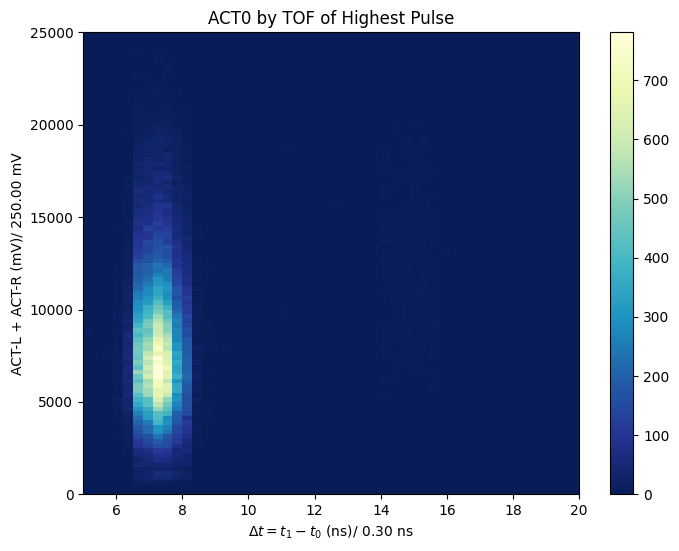

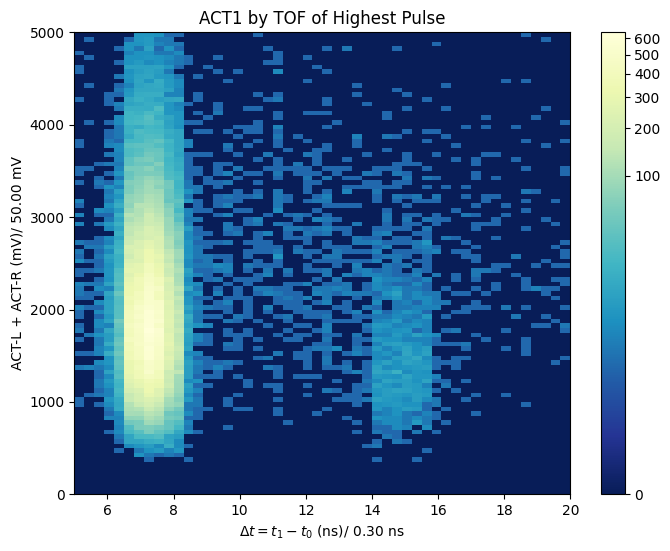

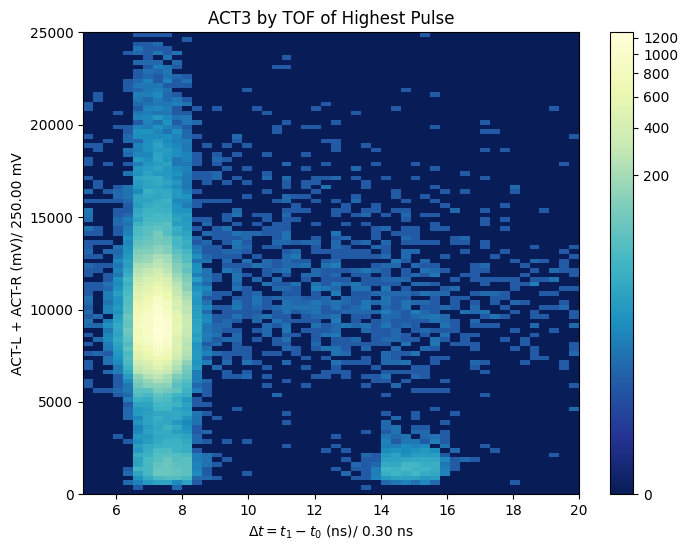

In [58]:
plot(act0, TOF0, hmin=5, hmax=20, hbins=50, title="ACT0 by TOF of Highest Pulse")
plot(act1, TOF0, hmin=5, hmax=20, hbins=50, title="ACT1 by TOF of Highest Pulse", gamma=0.2, vmax=5000)
plot(act3, TOF0, hmin=5, hmax=20, hbins=50, title="ACT3 by TOF of Highest Pulse", gamma=0.2, vmax=25000)

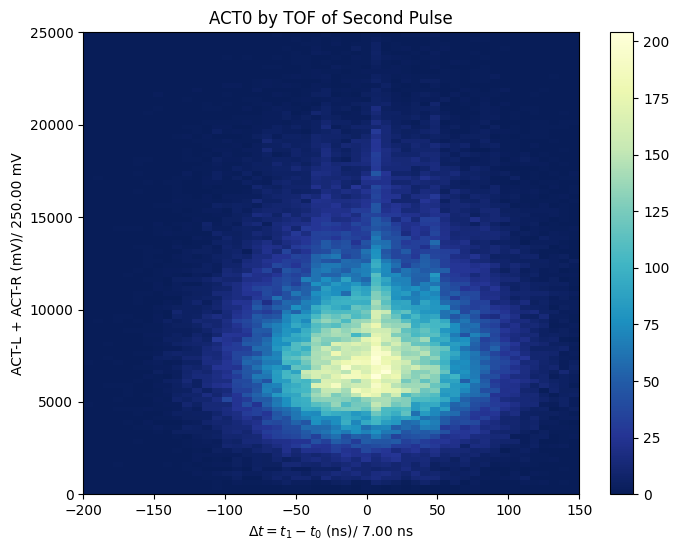

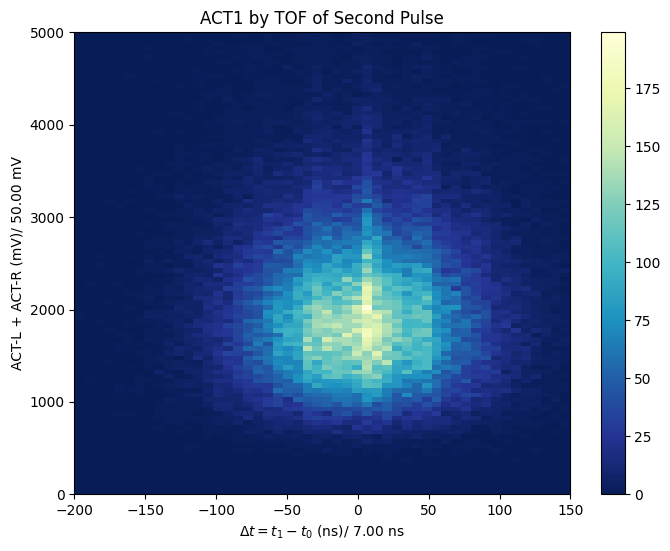

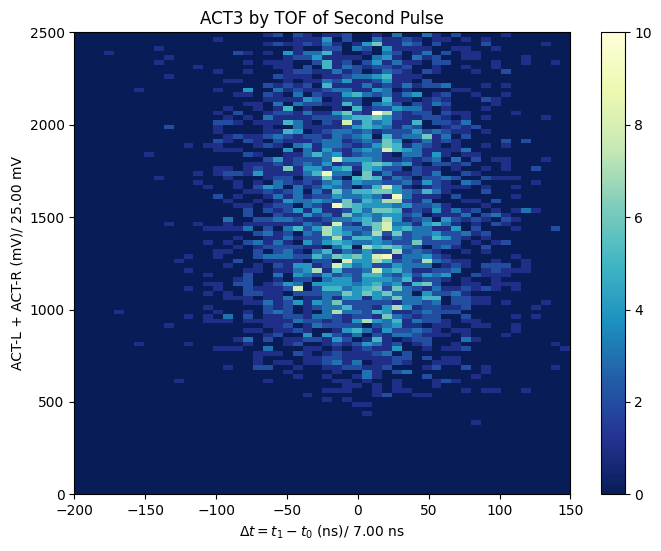

In [59]:
plot(act0, TOF1, hmin=-200, hmax=150, hbins=50, title="ACT0 by TOF of Second Pulse")
plot(act1, TOF1, hmin=-200, hmax=150, hbins=50, title="ACT1 by TOF of Second Pulse", vmax=5000)
plot(act3, TOF1, hmin=-200, hmax=150, hbins=50, title="ACT3 by TOF of Second Pulse", vmax=2500)

In [33]:
def find_pb_minimum(amplitude, channel):
    pb = []
    for i in range(0, len(amplitude)):               
        if len(amplitude[i][channel])> 0:
            pb.append(min(amplitude[i][channel]))
        else:
            pb.append(None)
    return pb

def prepare_to_plot_pb(pb, TOF0):
    final_tof0, final_pb = [], []
    for i in range(0, len(pb)):
        if pb[i] != None and TOF0[i] != None:
            final_tof0.append(TOF0[i])
            final_pb.append(-1.*pb[i])
    return np.array(final_pb), np.array(final_tof0)

def plot(act, tof, hbins=100, vbins=100, hmin=-8, hmax=50, vmin=0, vmax=25000, title=""):
    act_final, tof_final = prepare_to_plot_pb(act, tof)
    fig, ax0 = plt.subplots(nrows=1, ncols=1, sharey=True, sharex=True, figsize=(8,6))
    # histogram = ax0.hist2d(tof_final, act_final, cmap=plt.cm.YlGnBu_r)

    histogram = ax0.hist2d(tof_final, act_final, range=[[hmin,hmax],[vmin,vmax]], bins=[hbins, vbins], cmap=plt.cm.YlGnBu_r)
    
    hbin_width = histogram[1][2]-histogram[1][1]
    vbin_width = histogram[2][2]-histogram[2][1]
    
    ax0.set_xlabel(r"$\Delta t = t_1 - t_0$ (ns)"+f"/ {hbin_width:4.2f} ns")
    ax0.set_ylabel(r"ACT-L + ACT-R (mV)" + f"/ {vbin_width:4.2f} mV")
    if len(title)>0:
        ax0.set_title(title)
    
    plt.savefig(f"./plots/432 - {title}.png")

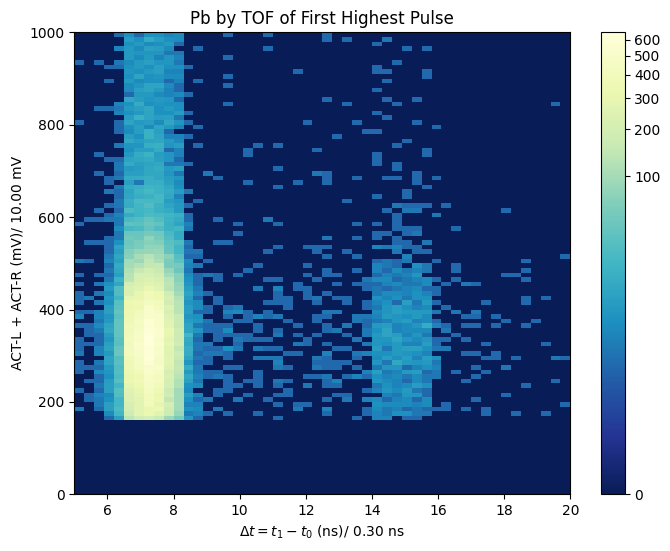

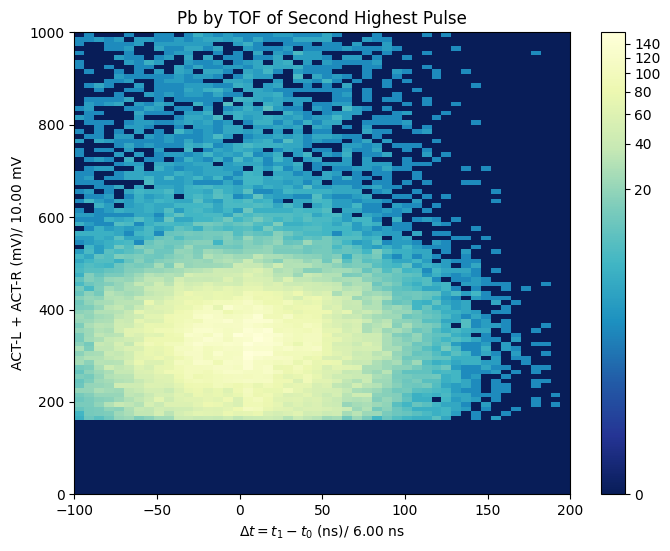

In [61]:
pb = find_pb_minimum(amplitude, 16)
plot(pb, TOF0, hmin=5, hmax=20, hbins=50, title="Pb by TOF of First Highest Pulse", gamma=0.2, vmax=1000)
plot(pb, TOF1, hmin=-100, hmax=200, hbins=50, title="Pb by TOF of Second Highest Pulse", gamma=0.2, vmax=1000)